# Modélisation 

### Import des modules

In [3]:
import warnings
# Filtrer les avertissements spécifiques de LightGBM
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#Imputation de mes données
from sklearn.impute import SimpleImputer

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    LearningCurveDisplay,
    RandomizedSearchCV
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer, mean_absolute_percentage_error

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, RobustScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
# qui nous permettent une automatisation lors de transformation de variable
from sklearn.compose import make_column_transformer, make_column_selector

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# On utilisera la librairie de scipy.stats pour explorer des plages continues en échelle precis.
from scipy.stats import randint, uniform, loguniform

### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes.
En règle générale : On utilise la méthode .apply() de Pandas pour créer une nouvelle colonne à partir d'une colonne existante. N'hésitez pas à regarder les exemples dans les chapitres de cours donnés en ressource

In [8]:
df_seattle = pd.read_csv('ville_de_seattle.csv')
df_seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PrimaryPropertyType        1080 non-null   object 
 1   YearBuilt                  1080 non-null   int64  
 2   NumberofBuildings          1080 non-null   float64
 3   NumberofFloors             1080 non-null   int64  
 4   LargestPropertyUseType     1080 non-null   object 
 5   LargestPropertyUseTypeGFA  1080 non-null   float64
 6   ENERGYSTARScore            717 non-null    float64
 7   SiteEnergyUseWN(kBtu)      1080 non-null   float64
 8   TotalGHGEmissions          1080 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 76.1+ KB


In [6]:
'''D'après l'annova qu'on a effectue dans la partie precedent :
Stratifiez sur PrimaryPropertyType car elle présente le plus fort pouvoir explicatif (F le plus élevé).
Possède des effectifs relativement suffisants après traitement des rares'''
trainset, testset = train_test_split(df_seattle, test_size = 0.2, random_state=0, stratify=df_seattle['PrimaryPropertyType'])
print(trainset.shape)
print(testset.shape)

(864, 9)
(216, 9)


In [8]:
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100



def evaluation(model, X_train, y_train, X_test, y_test):
    # Entraînement et prédiction
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calcul des métriques
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    wape_score = wape(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Affichage
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"WAPE : {wape_score:.2f}%")
    print(f"R²   : {r2:.4f}")

    # Courbe d’apprentissage
    LearningCurveDisplay.from_estimator(model, X_train, y_train, cv=4, scoring='r2')
    plt.title("Learning Curve (R²)")
    plt.tight_layout()
    plt.show()

    print("=" * 100)


## Modelisation de Consommation d'energie

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

* La transformation logarithmique de la cible a été testée, mais elle a dégradé les performances des modèles. La variable a donc été conservée dans sa forme originale.

In [14]:
def label_encode_columns(df):
    df_encoded = df.copy()
    for col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    return df_encoded

# Sélecteurs
num_selector = make_column_selector(dtype_include=[np.number])
cate_selector = make_column_selector(dtype_exclude=[np.number])

# Pipeline numérique
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    RobustScaler()
)

# Pipeline catégoriel - LabelEncoder
label_pipeline = make_pipeline(
    FunctionTransformer(label_encode_columns, validate=False)
)

# Assembleur
preprocessor = make_column_transformer(
    (num_pipeline, num_selector),
    (label_pipeline, cate_selector),
    verbose_feature_names_out=False
)

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [18]:
# CODE COMPARAISON DES MODELES
dummy = make_pipeline(preprocessor, DummyRegressor())
linear = make_pipeline(preprocessor, LinearRegression())
svr = make_pipeline(preprocessor, SVR())
random_F = make_pipeline(preprocessor, RandomForestRegressor(random_state=0))
xgb = make_pipeline(preprocessor, XGBRegressor(random_state=0))
g_boost= make_pipeline(preprocessor,GradientBoostingRegressor(random_state=0))
# régroupons nos models dans un dict
dict_of_models = {'Dummy' : dummy,
                  'Linear' : linear,
                  'SVR' : svr,
                  'RandomForest': random_F,
                  'XGB': xgb,
                 'GradiantBoosting': g_boost}

In [20]:
# Préparation des features pour la modélisation
# Version sans la variable 'ENERGYSTARScore'
X_train = trainset.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore'])
X_test = testset.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore'])

# Version alternative avec 'ENERGYSTARScore' (pour tester son impact)
X_train_opt = trainset.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])
X_test_opt = testset.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])

# Définition de la cible (total des émissions)
y_train = trainset['TotalGHGEmissions']
y_test  = testset['TotalGHGEmissions']

Dummy
RMSE : 853.3673
MAE  : 216.2251
MAPE : 715.57%
WAPE : 109.68%
R²   : -0.0002


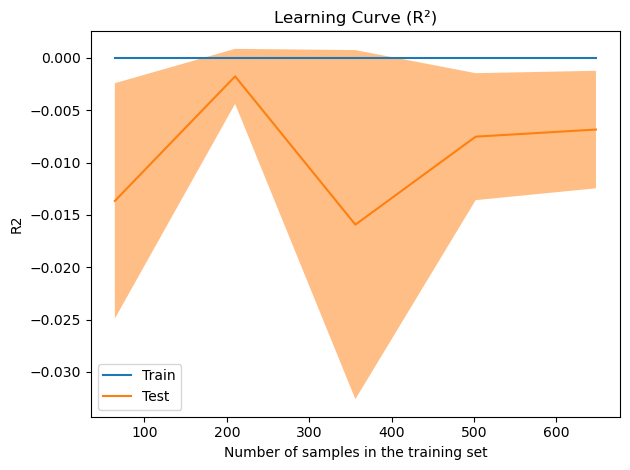

Linear
RMSE : 643.7009
MAE  : 196.9880
MAPE : 428.71%
WAPE : 99.92%
R²   : 0.4309


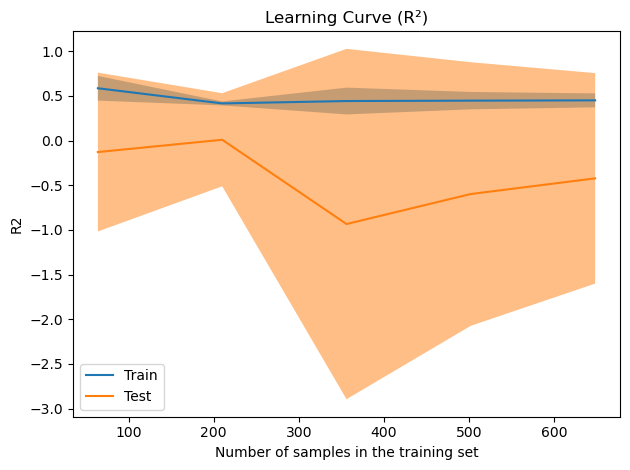

SVR
RMSE : 858.7205
MAE  : 162.6767
MAPE : 179.92%
WAPE : 82.52%
R²   : -0.0127


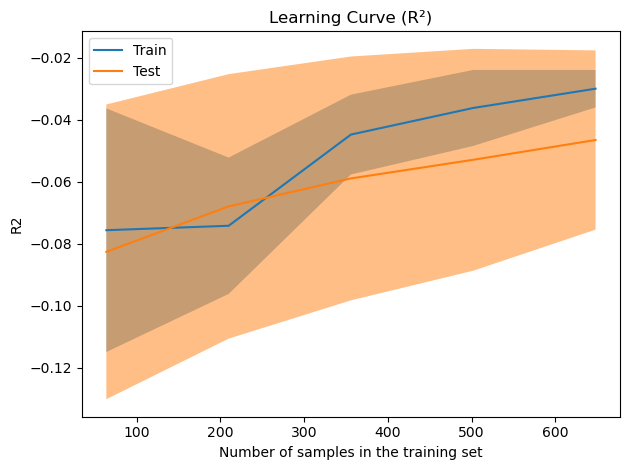

RandomForest
RMSE : 513.6137
MAE  : 128.6521
MAPE : 258.11%
WAPE : 65.26%
R²   : 0.6377


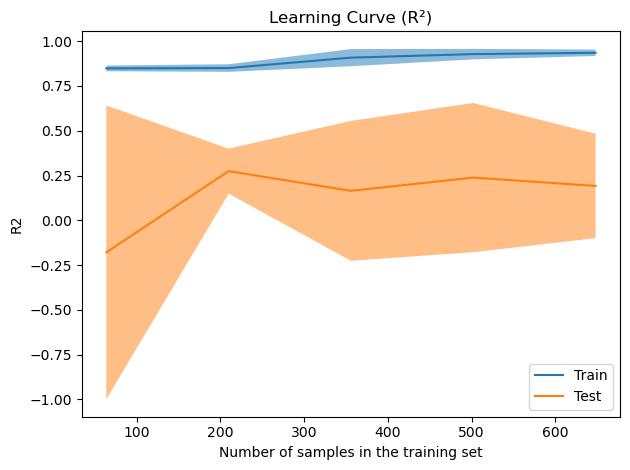

XGB
RMSE : 323.9684
MAE  : 125.9700
MAPE : 232.79%
WAPE : 63.90%
R²   : 0.8559


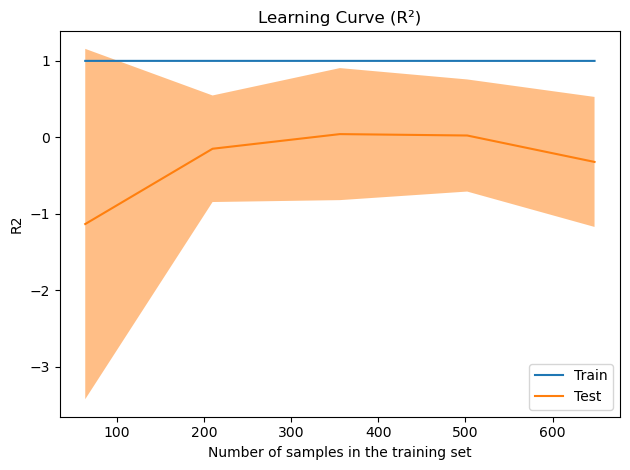

GradiantBoosting
RMSE : 544.5641
MAE  : 133.2827
MAPE : 226.58%
WAPE : 67.61%
R²   : 0.5927


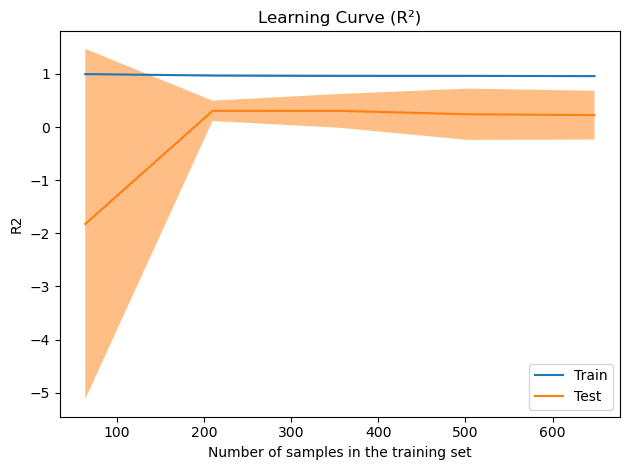

In [22]:
# Entrainnement et évaluation de nos models avec la variable 'ENERGYSTARScore'
for name, model in dict_of_models.items():
    print(name)
    evaluation(model, X_train_opt, y_train, X_test_opt, y_test)

Dummy
RMSE : 853.3673
MAE  : 216.2251
MAPE : 715.57%
WAPE : 109.68%
R²   : -0.0002


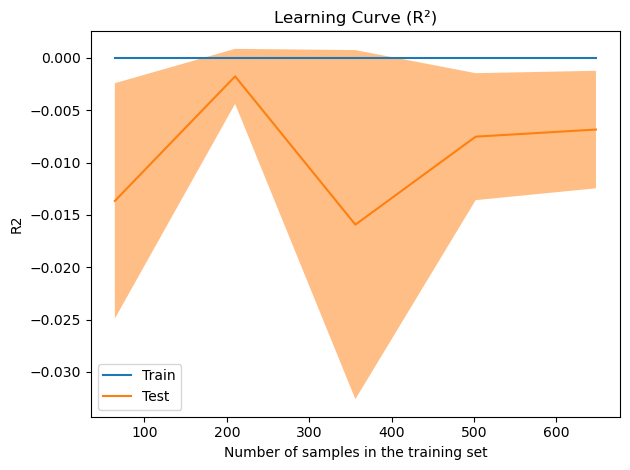

Linear
RMSE : 644.4004
MAE  : 180.6880
MAPE : 339.72%
WAPE : 91.65%
R²   : 0.4297


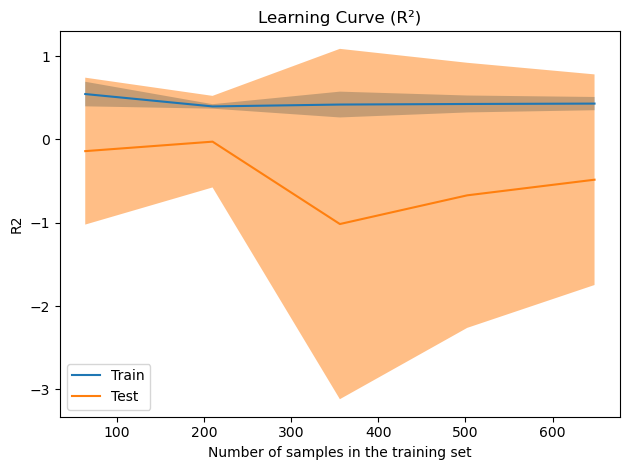

SVR
RMSE : 858.5885
MAE  : 162.6245
MAPE : 181.14%
WAPE : 82.49%
R²   : -0.0124


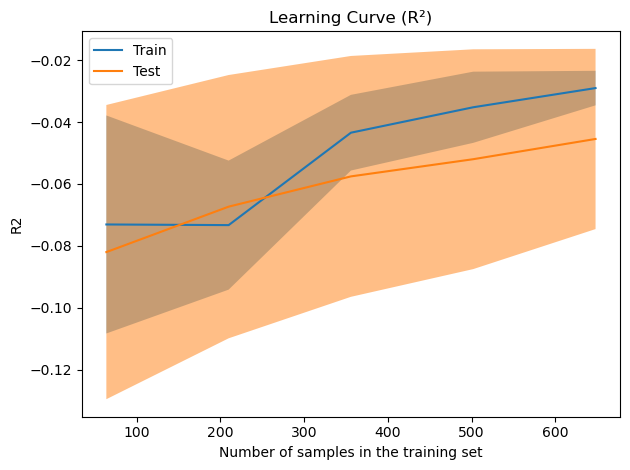

RandomForest
RMSE : 345.5053
MAE  : 107.1197
MAPE : 253.67%
WAPE : 54.34%
R²   : 0.8361


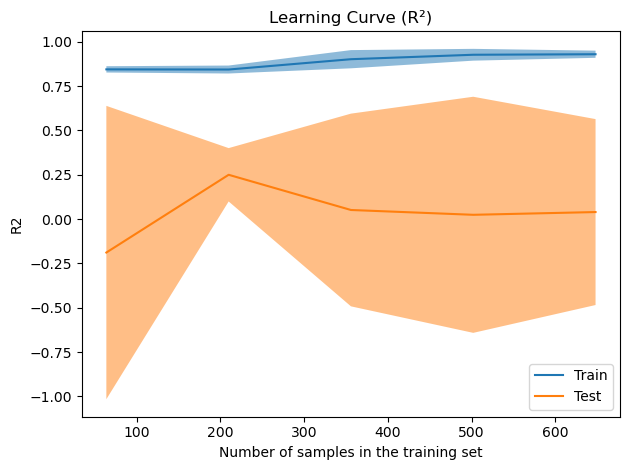

XGB
RMSE : 194.5504
MAE  : 103.4811
MAPE : 227.52%
WAPE : 52.49%
R²   : 0.9480


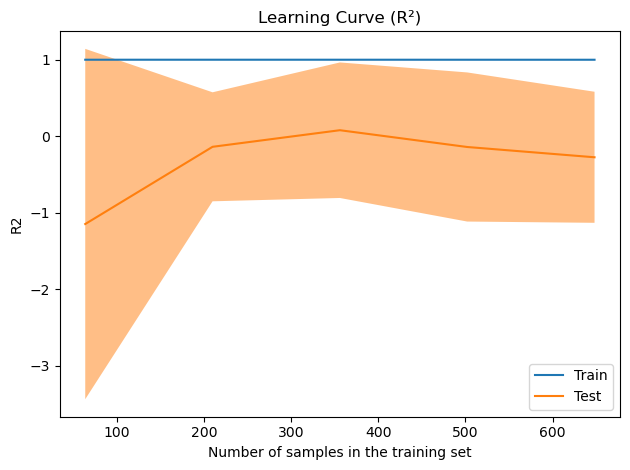

GradiantBoosting
RMSE : 219.2972
MAE  : 93.7291
MAPE : 245.69%
WAPE : 47.54%
R²   : 0.9340


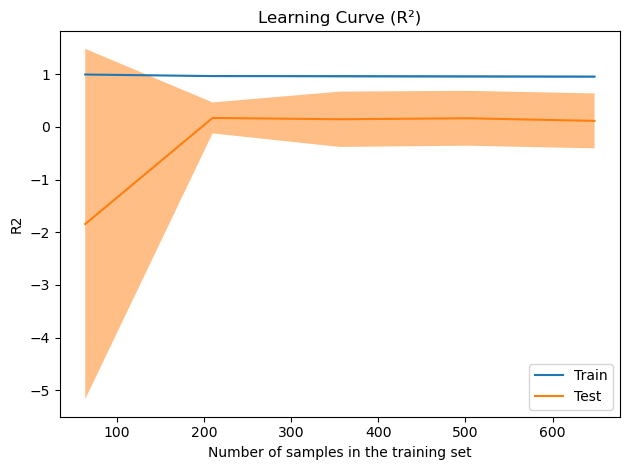

In [24]:
# Entrainnement et évaluation de nos models sans la variable 'ENERGYSTARScore'
for name, model in dict_of_models.items():
    print(name)
    evaluation(model, X_train, y_train, X_test, y_test)

CE QU'ON OBSERVE :
- Tous les modèles (sauf Dummy et SVR) ont de meilleures performances sans la variable `ENERGYSTARScore`.
- XGBoost et Gradient Boosting montrent une amélioration spectaculaire en RMSE et R² lorsque la variable est retirée :
- XGB : R² passe de 0.86 ➝ 0.95, RMSE baisse de 323 ➝ 194
- GradientBoosting : R² passe de 0.59 ➝ 0.93, RMSE baisse de 544 ➝ 219
_ _ _

CONCLUSION :
- Cela suggère que ENERGYSTARScore pourrait introduire du bruit ou de la redondance avec d’autres variables pour la prédiction des émissions de CO₂.
- Meilleur modèle global (R² + RMSE) → XGBoost. Meilleur en termes de WAPE → Gradient Boosting.
- Les MAPE sont peu interprétables ici à cause des divisions par de petites valeurs cibles, donc à prendre avec précaution.
- Prochaine étape → hyperparam tuning sur XGB et GradientBoosting pour voir si on peut encore réduire le WAPE sans perdre le R².

* Voici les deux model choisie pour optimisation : `XGB` et `GradiantBoosting`

### Optimisation et interprétation du modèle

**METHODE OPTIMISATION :**
* Pour optimiser les hyperparamètres de mes modèles, j’ai adopté une démarche progressive en deux étapes : une première phase d’exploration large avec RandomizedSearchCV afin d’identifier les zones prometteuses dans l’espace des paramètres, suivie d’une phase de recherche plus ciblée avec GridSearchCV utilisant des listes explicites, resserrant ainsi la recherche autour des meilleurs paramètres trouvés pour affiner la performance du modèle.

#### OPTIMISATION DU MODEL `GradiantBoosting`

In [29]:
scoring = {
    'R2': make_scorer(r2_score),
    'RMSE': make_scorer(lambda y_test, y_pred: np.sqrt(mean_squared_error(y_test, y_pred)),
                        greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'WAPE': make_scorer(lambda y_test, y_pred: wape(y_test, y_pred),
                        greater_is_better=False)
}

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'gradientboostingregressor__learning_rate': 0.18264225336276368, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__min_samples_leaf': 3, 'gradientboostingregressor__min_samples_split': 5, 'gradientboostingregressor__n_estimators': 42, 'gradientboostingregressor__subsample': 0.8374763254003454}
RMSE : 231.2335
MAE  : 97.0343
MAPE : 266.58%
WAPE : 49.22%
R²   : 0.9266


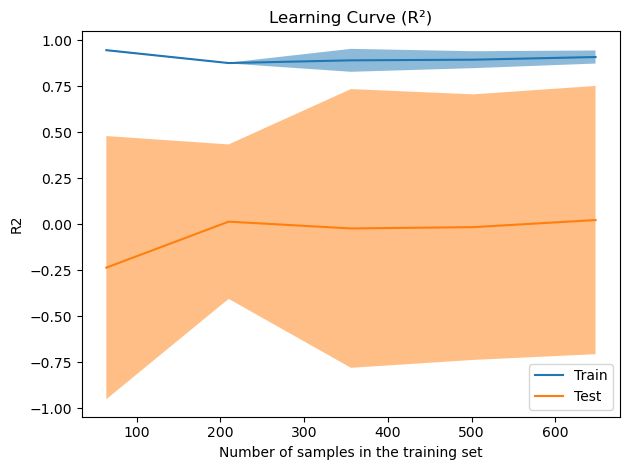

In [31]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE GradientBoosting
param_dist_gb = {
    # n_estimators : tune entre 10 et 100 (100 = défaut)
    'gradientboostingregressor__n_estimators': randint(10, 101),

    # learning_rate : tune entre 0.01 et 0.31 (0.1 = défaut)
    'gradientboostingregressor__learning_rate': uniform(0.01, 0.30),

    # max_depth : tune entre 2 et 7 (3 = défaut)
    'gradientboostingregressor__max_depth': randint(2, 8),

    # subsample : tune entre 0.7 et ~1.0001 (1.0 = défaut)
    'gradientboostingregressor__subsample': uniform(0.7, 0.300001),

    # min_samples_split : tune entre 2 et 9 (2 = défaut)
    'gradientboostingregressor__min_samples_split': randint(2, 10),

    # min_samples_leaf : tune entre 1 et 9 (1 = défaut)
    'gradientboostingregressor__min_samples_leaf': randint(1, 10),
}

grid_RS = RandomizedSearchCV(
    g_boost, param_dist_gb, n_iter=100, cv=5, 
    scoring=scoring, refit='RMSE', n_jobs=-1, verbose=2, random_state=42
)

grid_RS.fit(X_train, y_train)

print(grid_RS.best_params_)
evaluation(grid_RS.best_estimator_, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits
{'gradientboostingregressor__learning_rate': 0.2, 'gradientboostingregressor__max_depth': 4, 'gradientboostingregressor__min_samples_leaf': 3, 'gradientboostingregressor__min_samples_split': 4, 'gradientboostingregressor__n_estimators': 42, 'gradientboostingregressor__subsample': 0.84}
RMSE : 250.7761
MAE  : 102.4547
MAPE : 267.35%
WAPE : 51.97%
R²   : 0.9136


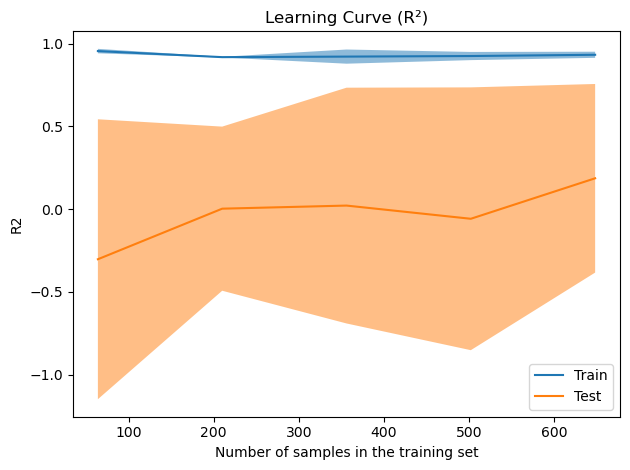

In [37]:
# Espace de recherche réduit pour GridSearchCV
param_dist_gb = {
    'gradientboostingregressor__learning_rate': [0.15, 0.18, 0.20],
    'gradientboostingregressor__max_depth': [2, 3, 4],
    'gradientboostingregressor__min_samples_leaf': [2, 3, 4],
    'gradientboostingregressor__min_samples_split': [4, 5, 6],
    'gradientboostingregressor__n_estimators': [35, 40, 42, 45, 50],
    'gradientboostingregressor__subsample': [0.82, 0.84, 0.86]
}

grid_GS = GridSearchCV(
    g_boost, param_dist_gb, cv=5, scoring=scoring, refit='RMSE',
    n_jobs=-1, verbose=2)

grid_GS.fit(X_train, y_train)

print(grid_GS.best_params_)
evaluation(grid_GS.best_estimator_, X_train, y_train, X_test, y_test)

#### OPTIMISATION DU MODEL `XGBoost`

Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'xgbregressor__gamma': 0.42545153795217594, 'xgbregressor__learning_rate': 0.15598711801832746, 'xgbregressor__max_depth': 2, 'xgbregressor__n_estimators': 65, 'xgbregressor__subsample': 0.874995310555126}
RMSE : 358.3312
MAE  : 108.7509
MAPE : 280.47%
WAPE : 55.16%
R²   : 0.8237


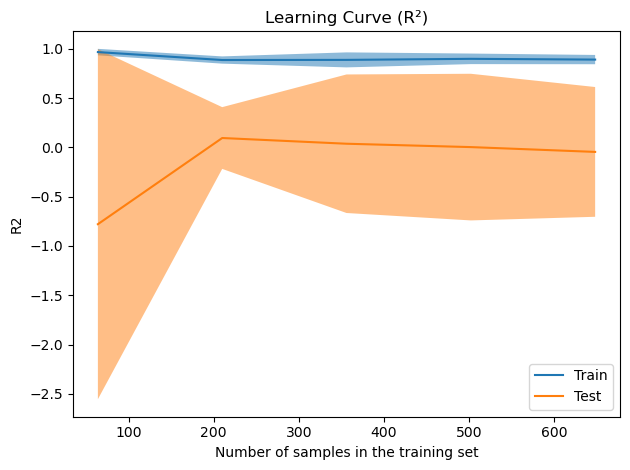

In [39]:

param_dist_xgb = {
    # n_estimators : tune entre 10 et 100 (100 = valeur par défaut)
    "xgbregressor__n_estimators": randint(10, 101),        

    # learning_rate : log-uniform entre 0.001 et 0.3 (0.3 = défaut)
    "xgbregressor__learning_rate": loguniform(1e-3, 0.3),  

    # max_depth : tune entre 2 et 8 (6 = défaut)
    "xgbregressor__max_depth": randint(2, 9),               

    # subsample : uniforme entre 0.6 et 1.0 (1.0 = défaut)
    "xgbregressor__subsample": uniform(0.6, 0.4),           

    # gamma : uniforme entre 0 et 1 (0 = défaut)
    "xgbregressor__gamma": uniform(0, 1)
}


grid_RS = RandomizedSearchCV(xgb, param_dist_xgb, n_iter=80, cv=5, scoring=scoring, refit='RMSE', 
    n_jobs=-1, verbose=2, random_state=0)

grid_RS.fit(X_train, y_train)

print(grid_RS.best_params_)
evaluation(grid_RS.best_estimator_, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
{'xgbregressor__gamma': 0.3, 'xgbregressor__learning_rate': 0.18, 'xgbregressor__max_depth': 2, 'xgbregressor__n_estimators': 65, 'xgbregressor__subsample': 0.85}
RMSE : 385.0942
MAE  : 112.3548
MAPE : 277.84%
WAPE : 56.99%
R²   : 0.7963


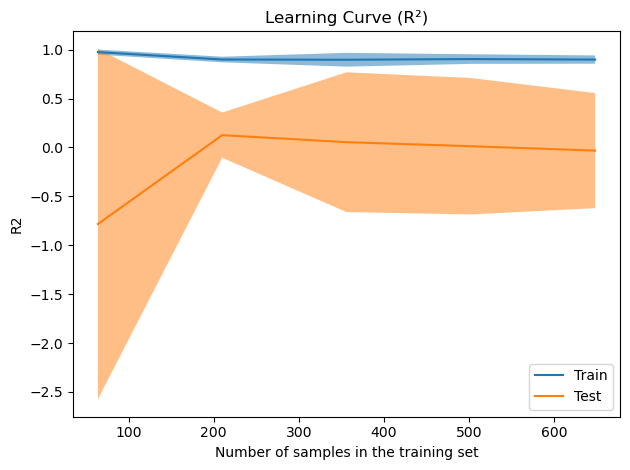

In [45]:
param_dist_xgb = {
    'xgbregressor__gamma': [0.3, 0.4, 0.43, 0.5],
    'xgbregressor__learning_rate': [0.14, 0.155, 0.16, 0.18],
    'xgbregressor__max_depth': [1, 2, 3],
    'xgbregressor__n_estimators': [60, 65, 70],
    'xgbregressor__subsample': [0.85, 0.87, 0.9]
}


grid_GS = GridSearchCV(
    xgb, param_dist_xgb, cv=3, scoring=scoring, refit='RMSE',
    n_jobs=-1, verbose=2)

grid_GS.fit(X_train, y_train)

print(grid_GS.best_params_)
evaluation(grid_GS.best_estimator_, X_train, y_train, X_test, y_test)

## Interpretation de mon model

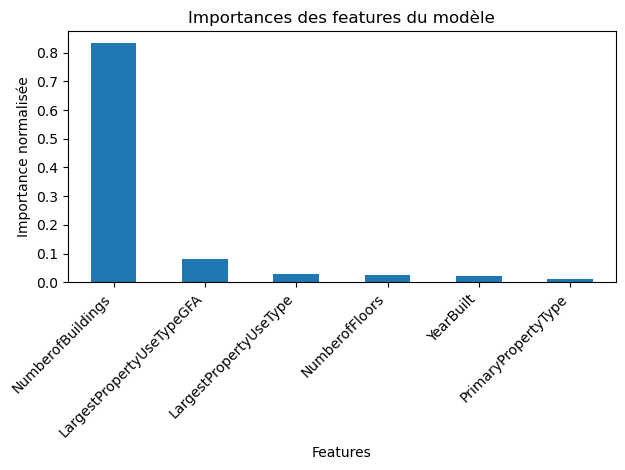

In [47]:
final_model = make_pipeline(preprocessor, XGBRegressor(random_state=0))
final_model.fit(X_train,y_train)


# 1. Extraction de la liste des colonnes numériques et catégorielles
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
# 2. Construisons la liste finale dans l’ordre d’application du ColumnTransformer
feature_names = num_cols + cat_cols

# 3. Récupérons l’estimateur xgbregressor du pipeline
XGB= final_model.named_steps['xgbregressor']

# 4. Créons la Series d’importances
importances = pd.Series(XGB.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)

# 4. Visualisons
importances.plot.bar()
plt.title("Importances des features du modèle")
plt.ylabel("Importance normalisée")
plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

* `NumberofBuildings` est de loin le déterminant principal du comportement de votre cible Le modèle a appris que plus le nombre de bâtiments (ou leur configuration) varie, plus la cible fluctue. Cette variable porte donc l’essentiel de la corrélation.
* `LargestPropertyUseTypeGFA` apporte un éclairage secondaire La surface utile du type d’usage majeur intervient, mais avec un effet près de 8 fois moindre que NumberofBuildings.
* Les autres variables sont quasi inertes Que ce soit le type d’usage principal (categoriel), l’année de construction, le nombre d’étages ou le PrimaryPropertyType, leur importance est quasiment nulle. Le modèle n’a pas trouvé chez elles d’information supplémentaire pertinente.